## Objective: Use Latent Dirichlet Allocation to identify common themes in articles nominated for deletion
* Following along with a tutorial: https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html

In [58]:
from bs4 import BeautifulSoup
import boto3
import config as cfg
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import Phrases
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
from pprint import pprint
import seaborn as sns
import yaml

In [2]:
%run "../libraries/aws_utils.ipynb"

In [3]:
%run "../libraries/general_utils.ipynb"

In [4]:
with open('../data_engineering/config.yml', 'r') as file:
   config_files = yaml.safe_load(file)

In [5]:
NUM_TOPICS = 5 # number of topics to fit on LDA model

## Load wiki articles

In [9]:
s3_reader = boto3.resource('s3',
                    region_name='us-east-1',
                    aws_access_key_id=cfg.aws_reader['accessCode'],
                    aws_secret_access_key=cfg.aws_reader['secretCode'])

In [10]:
preprocessed_articles = read_parquet_file(s3_reader, 
                                  config_files['INTEREDIARY_OUTPUT_BUCKET'], 
                      config_files['PREPROCESSED_ARTICLE_TEXT'],
                                          )
test_primary_key(preprocessed_articles, ['article_id', 'file_name'])

In [11]:
preprocessed_articles[0:3]

,article_id,file_name,scraped_path,num_male_tokens,num_female_tokens,num_non_binary_tokens,num_neo_tokens,max_pronoun_column,afd_result,discussion,articles_text,article_body_text,afd_warning_element,notability_warning_element,article_body_text_wo_warning,article_body_text_wo_common_warning,article_body_text_wo_warning_remove_edit
0,A.S.D._Villabiagio,daily_afd_log/2023-01-03/2022_December_23.txt,individual_afd_page_html/2023-01-01/A.S.D._Vil...,1,0,0,0,male,keep,"<div class=""boilerplate afd vfd xfd-closed arc...","<!DOCTYPE html>\n<html class=""client-nojs"" lan...",Italian football club \n Football club Villabi...,[],[],Italian football club \n Football club Villabi...,Italian football club \n Football club Villabi...,Italian football club Football club Villabia...
1,Aaron_Kemmer,daily_afd_log/2023-01-19/2023_January_8.txt,individual_afd_page_html/2023-01-01/Aaron_Kemm...,5,0,2,0,male,delete,"<div class=""boilerplate afd vfd xfd-closed arc...","<!DOCTYPE html>\n<html class=""client-nojs"" lan...",This article is being considered for deletion ...,[This article is being considered for deletion...,[This article is being considered for deletion...,\n Aaron Kemmer Aaron Kemmer during Parabolic...,\n Aaron Kemmer Aaron Kemmer during Parabolic...,Aaron Kemmer Aaron Kemmer during Parabolic ...
2,Abbas_Sajwani,daily_afd_log/2023-01-07/2022_December_27.txt,individual_afd_page_html/2023-01-01/Abbas_Sajw...,1,0,0,0,male,delete,"<div class=""boilerplate afd vfd xfd-closed arc...","<!DOCTYPE html>\n<html class=""client-nojs"" lan...",This article is being considered for deletion ...,[This article is being considered for deletion...,[This article is being considered for deletion...,\n Abbas Sajwani is the son of Hussain Sajw...,\n Abbas Sajwani is the son of Hussain Sajw...,Abbas Sajwani is the son of Hussain Sajwa...


## Pre-process and vectorize the documents
Among other things, we will:

Split the documents into tokens.
Lemmatize the tokens.
Compute bigrams.
Compute a bag-of-words representation of the data.
First we tokenize the text using a regular expression tokenizer from NLTK. We remove numeric tokens and tokens that are only a single character, as they don't tend to be useful, and the dataset contains a lot of them.

In [13]:
female_docs = preprocessed_articles[preprocessed_articles['max_pronoun_column']=="female"]['article_body_text_wo_warning_remove_edit'].values
male_docs = preprocessed_articles[preprocessed_articles['max_pronoun_column']=="male"]['article_body_text_wo_warning_remove_edit'].values

In [14]:
def tokenize(docs):
    # Split the documents into tokens.
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]
    return docs

female_docs = tokenize(female_docs)
male_docs = tokenize(male_docs)

In [15]:
female_docs[0][0:10]

['american',
 'sports',
 'journalist',
 'born',
 'abby',
 'chin',
 'born',
 'is',
 'an',
 'american']

## Lemmatize

In [16]:
# Lemmatize the documents.

def lemmatize(docs):
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    return docs


female_docs = lemmatize(female_docs)
male_docs = lemmatize(male_docs)

In [17]:
female_docs[0][-10:]

['covering', 'the', 'nba', 'she', 'is', 'married', 'and', 'ha', 'two', 'child']

## Bigrams

In [18]:
def bigramize(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=5)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs
                
female_docs = bigramize(female_docs)
male_docs = bigramize(male_docs)

In [19]:
female_docs[0][-20:]

['and',
 'television',
 'before',
 'becoming',
 'sideline',
 'reporter',
 'covering',
 'the',
 'nba',
 'she',
 'is',
 'married',
 'and',
 'ha',
 'two',
 'child',
 'is_an',
 'a_well',
 'she_studied',
 'is_married']

## Remove stop words

In [20]:
# Remove rare and common tokens.
def create_dictionary(docs):
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=5, no_above=0.25)
    return dictionary

female_dict = create_dictionary(female_docs)
male_dict = create_dictionary(male_docs)

In [21]:
def create_corpus(dictionary, docs):
    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return corpus

female_corpus = create_corpus(female_dict, female_docs)
male_corpus = create_corpus(male_dict, male_docs)

In [22]:
print('Number of unique tokens: %d' % len(female_dict))
print('Number of documents: %d' % len(female_corpus))

Number of unique tokens: 825
Number of documents: 113


In [23]:
print('Number of unique tokens: %d' % len(male_dict))
print('Number of documents: %d' % len(male_corpus))

Number of unique tokens: 2880
Number of documents: 321


## Tune hyperparameters and track coherence scores

In [60]:
def train_model(dictionary, corpus, NUM_TOPICS):
    
    # Train LDA model.
    # Set training parameters.
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                           alpha='auto', eta='auto', \
                           iterations=iterations, num_topics=NUM_TOPICS, \
                           passes=passes, eval_every=eval_every)
    
    return model

def get_topics(model, corpus, NUM_TOPICS):
    top_topics = model.top_topics(corpus, topn=10)
    return top_topics

def get_topic_coherence(model, corpus, NUM_TOPICS):
    top_topics = model.top_topics(corpus, topn=10)
    # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
    avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
    return avg_topic_coherence

In [61]:
def fit_models_track_coherence(training_dict, corpus):
    N_TOPICS = [x for x in range(2, 11)]
    coherence_scores = []
    for n in N_TOPICS:
        model = train_model(training_dict, corpus, n)
        coherence_score = get_topic_coherence(model, corpus, n)
        coherence_scores = coherence_scores + [coherence_score,]
    return pd.DataFrame({"n_topics": N_TOPICS,
                        "coherence_score": coherence_scores})

In [62]:
female_model_coherences = fit_models_track_coherence(female_dict, female_corpus)

Text(0.5, 1.0, 'Female model coherence scores by n_topics - Higher scores are better')

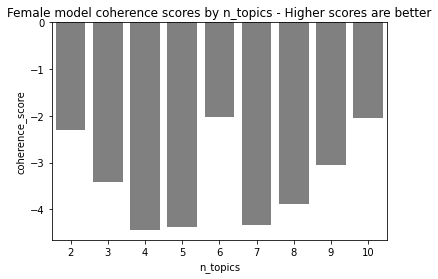

In [71]:
g = sns.barplot(data=female_model_coherences, 
            x = 'n_topics', y='coherence_score', color="gray")
g.set_title('Female model coherence scores by n_topics - Higher scores are better')

In [63]:
male_model_coherences = fit_models_track_coherence(male_dict, male_corpus)

Text(0.5, 1.0, 'Male model coherence scores by n_topics')

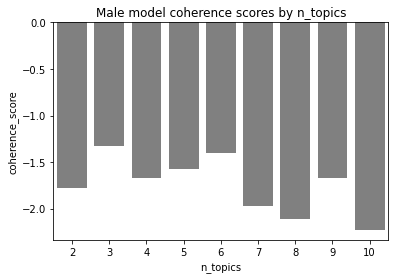

In [72]:
g = sns.barplot(data=male_model_coherences, 
            x = 'n_topics', y='coherence_score', color="gray")
g.set_title('Male model coherence scores by n_topics')

In [66]:
def get_best_n_topics(coherence_df):
    # Find the row with the highest score
    highest_score_row = coherence_df[coherence_df['coherence_score'] == coherence_df['coherence_score'].max()]

    # Get the parameter value from the highest_score_row
    parameter_with_highest_score = highest_score_row['n_topics'].values[0]
    return parameter_with_highest_score

best_n_female = get_best_n_topics(female_model_coherences)
best_n_male = get_best_n_topics(male_model_coherences)


In [67]:
best_n_female

6

In [73]:
best_n_male

3

In [74]:
female_model = train_model(female_dict, female_corpus, best_n_female)

In [75]:
male_model = train_model(male_dict, male_corpus, best_n_male)

In [82]:
female_topic_inference = get_topics(female_model, female_corpus, best_n_female)

In [83]:
male_topic_inference = get_topics(male_model, male_corpus, best_n_male)

## Classify documents

In [84]:
female_topics = [female_model.get_document_topics(doc) for doc in female_corpus]

In [85]:
# For each document, get the topic index with the maximum probability
most_likely_topic = [max(doc, key=lambda x: x[1])[0] for doc in female_topics]

In [86]:
def get_doc_indices(topic_index, most_likely_topic_index_list):
    """
    Retrieves the indices of elements equal to a specified topic index.

    Parameters:
        topic_index (int): The topic index to search for.
        most_likely_topic_index_list (list): A list of topic indices.

    Returns:
        list: A list of indices where the elements in most_likely_topic_index_list are equal to the specified topic_index.

    Description:
        This function takes a topic_index and a list of topic indices (most_likely_topic_index_list) as input. It searches
        through the most_likely_topic_index_list and returns a list of indices where the elements are equal to the specified
        topic_index.

    Example:
        # Define a list of topic indices
        topic_indices = [1, 3, 2, 3, 1, 3]

        # Get the indices of elements equal to 3
        indices = get_doc_indices(3, topic_indices)

        # Print the indices
        print(indices)
        # Output: [1, 3, 5]

    Note:
        The returned indices represent the positions of the elements in the most_likely_topic_index_list where the values
        are equal to the specified topic_index. The indices are 0-based.
    """
    indices = [index for index, value in enumerate(most_likely_topic_index_list) if value == topic_index]
    return indices


In [107]:
def print_matching_words(topic_inference, docs, topic_doc_indices):
    """
    Print the matching words between docs and words from topic_inference for the documents
    specified by topic_doc_indices.

    Parameters:
        topic_inference (list): List containing topic inference data.
        docs (list): List of documents.
        topic_doc_indices (list): List of indices representing the documents of interest.

    Returns:
        None

    Description:
        This function prints the docs that correspond to the topic_doc_indices. It then checks for the presence
        of matching words between the docs and words from topic_inference for each document. If a matching
        word is found, it is printed along with the statement 'FOUND'. The function adds a separator '*********' 
        between each document's output for clarity.

    Example:
        # Obtain topic_inference, docs, and topic_doc_indices

        # Call the function
        print_matching_words(topic_inference, docs, topic_doc_indices)

    Note:
        - The function assumes that the elements of topic_inference are in the format: (index, word).
        - docs and topic_inference should be appropriately populated prior to calling this function.
    """
    words = [word for _, word in topic_inference[0]]

    for doc in topic_doc_indices:
        matching_words = []
        for word in words:
            if word in docs[doc]:
                matching_words = matching_words + [word]
        if len(matching_words) > 0:
            print(f'FOUND {len(matching_words)} matching words: {matching_words}')
        else:
            print('Found no matching words')
        max_cap = min(100, len(docs[doc]))
        print(docs[doc][0:max_cap])
        print('*********')


### Review example output of topic 0

In [108]:
topic_0_doc_indices = get_doc_indices(0, most_likely_topic)

In [109]:
female_topic_inference[0]

([(0.033130754, 'model'),
  (0.029839894, 'single'),
  (0.020598672, 'digital'),
  (0.017746834, 'may'),
  (0.016296778, 'russian'),
  (0.016023409, 'article'),
  (0.014209497, 'album'),
  (0.011108207, 'name'),
  (0.009900401, 'music'),
  (0.009652285, 'or')],
 -1.3059450322298116)

In [110]:
print_matching_words(female_topic_inference[0], female_docs, topic_0_doc_indices)

Found no matching words
['american', 'sport', 'journalist', 'born', 'abby', 'chin', 'born', 'is', 'an', 'american', 'sport', 'journalist', 'she', 'is', 'boston', 'celtic', 'basketball', 'pregame', 'and', 'postgame', 'reporter', 'a', 'well', 'a', 'court', 'side', 'reporter', 'she', 'studied', 'broadcasting', 'at', 'the', 'university', 'of', 'colorado', 'boulder', 'and', 'later', 'interned', 'in', 'colorado', 'sport', 'radio', 'and', 'television', 'before', 'becoming', 'sideline', 'reporter', 'covering', 'the', 'nba', 'she', 'is', 'married', 'and', 'ha', 'two', 'child', 'is_an', 'a_well', 'she_studied', 'is_married']
*********
Found no matching words
['aiyshwarya', 'mahadev', 'secretary', 'all', 'india', 'mahila', 'congress', 'incumbent', 'assumed', 'office', 'march', 'aicc', 'spokesperson', 'in', 'office', 'january', 'march', 'personal', 'detail', 'born', 'december', 'age', 'bangalore', 'political', 'party', 'indian', 'national', 'congress', 'spouse', 'karthik', 'parent', 'manchanahalli

### Review example output of topic 1

In [111]:
topic_1_doc_indices = get_doc_indices(1, most_likely_topic)

In [112]:
female_topic_inference[1]

([(0.020730913, 'news'),
  (0.020142777, 'actress'),
  (0.017922675, 'series'),
  (0.017557796, 'award'),
  (0.016336575, 'tv'),
  (0.014602149, 'star'),
  (0.014178568, 'week'),
  (0.013578359, 'best'),
  (0.013330646, 'mother'),
  (0.01067634, 'taylor')],
 -1.4315165243126242)

In [113]:
print_matching_words(female_topic_inference[1], female_docs, topic_1_doc_indices)

Found no matching words
['ayesha', 'erotica', 'background', 'information', 'also', 'known', 'a', 'ayesha', 'erotica', 'ayesha', 'nicole', 'smith', 'born', 'august', 'age', 'origin', 'huntington', 'beach', 'california', 'genre', 'pop', 'rap', 'electro', 'clash', 'occupation', 'singer', 'rapper', 'songwriter', 'producer', 'instrument', 'vocal', 'year', 'active', 'partner', 'brendon', 'jones', 'present', 'musical', 'artist', 'ayesha', 'huntington', 'jones', 'born', 'august', 'known', 'professionally', 'a', 'ayesha', 'erotica', 'is', 'an', 'american', 'producer', 'songwriter', 'and', 'former', 'singer', 'rapper', 'residing', 'in', 'irvine', 'california', 'she', 'is', 'known', 'for', 'her', 'image', 'and', 'music', 'that', 'resembles', '2000s', 'pop', 'hip', 'hop', 'while', 'focusing', 'on', 'theme', 'of', 'eroticism', 'and', 'sexual', 'liberation', 'ayesha', 'began', 'releasing', 'music', 'in', 'under', 'different', 'name', 'and', 'in', 'under', 'ayesha', 'erotica', 'she', 'rose']
********

### Review example output of topic 3

In [114]:
topic_3_doc_indices = get_doc_indices(3, most_likely_topic)

In [115]:
female_topic_inference[3]

([(0.05724875, 'day'),
  (0.03746219, 'week'),
  (0.03305842, 'house'),
  (0.023992136, 'not'),
  (0.023210106, 'were'),
  (0.02112545, 'nominated'),
  (0.019847715, 'nomination'),
  (0.016057948, 'no'),
  (0.011998852, 'will'),
  (0.011382222, 'winner')],
 -1.587680254788622)

In [116]:
print_matching_words(female_topic_inference[3], female_docs, topic_3_doc_indices)

Found no matching words
['english', 'actress', 'television', 'personality', 'and', 'interior', 'designer', 'carlton', 'gebbia', 'born', 'carlton', 'elizabeth', 'october', 'age', 'south', 'africa', 'other', 'name', 'carlton', 'lynx', 'occupation', 'actress', 'television', 'personality', 'interior', 'designer', 'year', 'active', 'present', 'spouse', 'david', 'gebbia', 'div', 'child', 'carlton', 'elizabeth', 'gebbia', 'born', 'october', 'is', 'an', 'american', 'actress', 'television', 'personality', 'and', 'interior', 'designer', 'gebbia', 'is', 'best', 'known', 'for', 'her', 'role', 'a', 'main', 'housewife', 'on', 'the', 'fourth', 'installment', 'of', 'the', 'real', 'housewife', 'of', 'beverly', 'hill', 'early', 'life', 'edit', 'gebbia', 'an', 'only', 'child', 'wa', 'born', 'in', 'south', 'africa', 'but', 'moved', 'to', 'london', 'at', 'young', 'age', 'and', 'finally', 'relocated', 'to', 'los', 'angeles', 'to', 'pursue', 'career', 'in', 'acting', 'gebbia']
*********
Found no matching wor

## Review output for male models

In [117]:
male_topics = [male_model.get_document_topics(doc) for doc in male_corpus]

In [118]:
# For each document, get the topic index with the maximum probability
most_likely_topic_male = [max(doc, key=lambda x: x[1])[0] for doc in male_topics]

In [119]:
topic_0_doc_indices_male = get_doc_indices(0, most_likely_topic_male)
male_topic_inference[0]

([(0.007990477, 'resident'),
  (0.006907501, 'her'),
  (0.0061644353, 'him'),
  (0.005537875, 'not'),
  (0.005250871, 'their'),
  (0.0050838115, 'game'),
  (0.004689005, 'party'),
  (0.0046462705, 'were'),
  (0.004304462, 'but'),
  (0.004242724, 'during')],
 -0.9674561627149018)

In [120]:
print_matching_words(male_topic_inference[0], male_docs, topic_0_doc_indices_male)

FOUND 2 matching words: ['their', 'during']
['aaron', 'kemmer', 'aaron', 'kemmer', 'during', 'parabolic', 'flight', 'occupation', 'entrepreneur', 'advisor', 'business', 'manager', 'program', 'developer', 'and', 'entrepreneur', 'known', 'for', 'founded', 'multiple', 'company', 'including', 'the', 'in', 'space', 'manufacturing', 'company', 'made', 'in', 'space', 'inc', 'and', 'the', 'virtual', 'assistant', 'on', 'demand', 'company', 'magic', 'aaron', 'kemmer', 'is', 'an', 'entrepreneur', 'advisor', 'business', 'manager', 'and', 'program', 'developer', 'he', 'founded', 'multiple', 'company', 'including', 'the', 'in', 'space', 'manufacturing', 'company', 'made', 'in', 'space', 'inc', 'and', 'the', 'virtual', 'assistant', 'on', 'demand', 'company', 'magic', 'aaron', 'kemmer', 'wa', 'also', 'judge', 'for', 'the', 'miss', 'earth', 'international', 'pageant', 'which', 'is', 'big', 'international', 'beauty', 'pageant', 'content', 'made', 'in', 'space', 'singularity', 'university', 'summer', 'pr

In [121]:
topic_1_doc_indices_male = get_doc_indices(1, most_likely_topic_male)
male_topic_inference[1]

([(0.0210078, 'goal'),
  (0.01521985, 'club'),
  (0.013091933, 'league'),
  (0.010296066, 'player'),
  (0.009250485, 'against'),
  (0.009217083, 'season'),
  (0.008643364, 'win'),
  (0.0074034464, 'cup'),
  (0.0073181456, 'match'),
  (0.0072009754, 'scored')],
 -1.3768671637005294)

In [122]:
print_matching_words(male_topic_inference[1], male_docs, topic_1_doc_indices_male)

FOUND 2 matching words: ['club', 'season']
['italian', 'football', 'club', 'football', 'club', 'villabiagio', 'full', 'name', 'associazione', 'sportiva', 'dilettantistica', 'villabiagio', 'founded', 'dissolved', 'ground', 'stadio', 'comunale', 'vestrelli', 'castiglione', 'della', 'valle', 'italy', 'serie', '7th', 'home', 'colour', 'away', 'colour', 'associazione', 'sportiva', 'dilettantistica', 'villabiagio', 'is', 'an', 'italian', 'association', 'football', 'club', 'based', 'in', 'villanova', 'marsciano', 'and', 'san', 'biagio', 'della', 'valle', 'umbria', 'at', 'the', 'beginning', 'of', 'the', 'season', 'villabiagio', 'renounces', 'participation', 'in', 'the', 'serie', 'and', 'cease', 'his', 'sporting', 'activity', 'content', 'history', 'foundation', 'serie', 'external', 'link', 'history', 'edit', 'foundation', 'edit', 'the', 'club', 'wa', 'founded', 'in', 'serie', 'edit', 'in', 'the', 'season', 'the', 'team', 'wa', 'promoted', 'for', 'the', 'first', 'time', 'from', 'eccellenza', 'um

In [123]:
topic_2_doc_indices_male = get_doc_indices(2, most_likely_topic_male)
male_topic_inference[2]

([(0.01402092, 'no'),
  (0.013192739, 'help'),
  (0.012097945, 'target'),
  (0.0069232057, 'director'),
  (0.006082186, 'film'),
  (0.005526544, 'award'),
  (0.0045041046, 'education'),
  (0.0044876416, 'producer'),
  (0.004055917, 'book'),
  (0.0037756728, 'art')],
 -1.8317042627462945)

In [124]:
print_matching_words(male_topic_inference[2], male_docs, topic_2_doc_indices_male)

FOUND 2 matching words: ['no', 'help']
['fictional', 'character', 'from', 'quantum', 'leap', 'fictional', 'character', 'al', 'calavicci', 'first', 'appearance', 'genesis', 'march', 'last', 'appearance', 'mirror', 'image', 'may', 'created', 'by', 'donald', 'bellisario', 'portrayed', 'by', 'dean', 'stockwell', 'in', 'universe', 'information', 'full', 'name', 'albert', 'calavicci', 'specie', 'human', 'gender', 'male', 'title', 'rear', 'admiral', 'occupation', 'pilot', 'companion', 'assistant', 'to', 'dr', 'sam', 'beckett', 'family', 'unnamed', 'father', 'deceased', 'unnamed', 'mother', 'trudy', 'calavicci', 'sister', 'deceased', 'spouse', 'beth', 'calavicci', 'child', 'four', 'daughter', 'youngest', 'is', 'janis', 'calavicci', 'relative', 'jack', 'uncle', 'stawpah', 'uncle', 'trudy', 'sister', 'rear', 'admiral', 'upper', 'half', 'albert', 'calavicci', 'usn', 'is', 'fictional', 'character', 'on', 'the', 'to', 'science', 'fiction', 'television', 'series', 'quantum', 'leap', 'played', 'by', 